In [1]:
import pandas as pd 
import os 
import time
from tqdm import tqdm 
from skimage.transform import resize 
from skimage.io import imread 
from skimage import feature as ft
import numpy as np 
from numpy import linalg as LA
import matplotlib.pyplot as plt 
from sklearn import svm 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
import argparse
import mahotas
import glob
import cv2

1.使用三種特徵萃取方式：HOG, Haralink and ORB\
2.設定完成三種萃取方式的def後，將資料進行特徵萃取和輸出（可以儲存起來避免每次重複進行）\
3.分成三部分：train,validation,test\
4.訓練模型：KNN(比較十種不同k結果),SVM,catboost\
5.輸出結果比較

In [151]:
# 將圖片資料的所在路徑與圖片資料分類label記錄（共兩百個圖片種類）
dd=os.listdir('TinyImageNet/TIN')
dd.remove(".DS_Store")
f1 = open('train.txt', 'w')
f2 = open('val.txt', 'w')
f3 = open('test.txt', 'w')
for i in tqdm(range(len(dd))):
    d2 = os.listdir ('TinyImageNet/TIN/%s/images/'%(dd[i]))
    # Train
    for j in range(len(d2)-4):
        str1='TinyImageNet/TIN/%s/images/%s'%(dd[i], d2[j])
        f1.write("%s %d\n" % (str1, i))
    # Validation
    str1='TinyImageNet/TIN/%s/images/%s'%(dd[i], d2[-3])
    f2.write("%s %d\n" % (str1, i))
    # Test
    str1='TinyImageNet/TIN/%s/images/%s'%(dd[i], d2[-2])
    f3.write("%s %d\n" % (str1, i))
    str1='TinyImageNet/TIN/%s/images/%s'%(dd[i], d2[-1])
    f3.write("%s %d\n" % (str1, i))
f1.close()
f2.close()
f3.close()

100%|██████████| 200/200 [00:00<00:00, 772.71it/s]


In [2]:
def ORB(image):
    img=cv2.resize(image, (128,128))
    # Initiate ORB detector
    orb = cv2.ORB_create(nlevels = 4,edgeThreshold = 8,patchSize=8)
    # find the keypoints with ORB
    kp = orb.detect(img,None)
    # compute the descriptors with ORB
    kp, des = orb.compute(img, kp)
    # draw only keypoints location,not size and orientation
    img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
    img2=cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) 
    # plt.imshow(img2), plt.show() 顯示特徵萃取後圖片
    img2=cv2.resize(img2, (16,16))

    return img2

def HOG(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # 將圖片灰階
    features = ft.hog(image, orientations=6, pixels_per_cell = [16,16],
                      cells_per_block = [2,2], visualize = True)
    features = cv2.resize(features[1], (16,16))
    
    return features

def describe(image, mask=None):
 
    #取RGB三個channels的平均及變異
    (means, stds) = cv2.meanStdDev(image)

    #合併平均及變異兩種數值再攤為一維
    colorRGB = np.concatenate([means, stds]).flatten()

    #取Haralink textures
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # 將圖片灰階
    hara = mahotas.features.haralick(image).mean(axis=0)

    #將兩種特徵值合併
    features = np.append(colorRGB, hara)

    return features

def load_img(f, FEAT = "Haralink"):
    f=open(f)
    lines=f.readlines()
    imgs, lab=[], []
    for i in tqdm(range(len(lines))):
        fn, label = lines[i].split(' ')
        
        im1=cv2.imread(fn)
        im1=cv2.resize(im1, (256,256)) # 確保每張圖片大小為64X64

        if FEAT == "Haralink":
            feature = describe(im1).tolist() # 利用Haralink進行特徵萃取
        elif FEAT == "HOG":
            feature = HOG(im1).tolist() # 利用HOG進行特徵萃取
        elif FEAT == "ORB":
            feature = ORB(im1).tolist()
        # im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) 
        
        
        vec = np.reshape(feature, [-1])
        imgs.append(vec) 
        lab.append(int(label))
        
    imgs= np.asarray(imgs, np.float32)
    lab= np.asarray(lab, np.int32)
    return imgs, lab 

In [3]:
# Train
Haralink_x, Haralink_y = load_img('train.txt')   # 進行Haralink特徵萃取
HOG_x, HOG_y = load_img('train.txt', FEAT="HOG") # 進行HOG特徵萃取
ORB_x, ORB_y = load_img('train.txt', FEAT="ORB") # 進行PRB特徵萃取
# Validation
Haralink_vx, Haralink_vy = load_img('val.txt')  
HOG_vx, HOG_vy = load_img('val.txt', FEAT="HOG") 
ORB_vx, ORB_vy = load_img('val.txt', FEAT="ORB") 
# Test
Haralink_tx, Haralink_ty = load_img('test.txt')  
HOG_tx, HOG_ty = load_img('test.txt', FEAT="HOG") 
ORB_tx, ORB_ty = load_img('test.txt', FEAT="ORB") 
#======================================
#X就是資料，Y是Label，設計不同分類器來得到最高效能
#判斷標準：計算出分類的正確率
#======================================

  0%|          | 0/99200 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:00<00:00, 723.34it/s]


In [4]:
print(f"Haralink dimension: {Haralink_x.shape}")
# 可以看到進行Haralink特徵萃取後，一張圖片會有19個變數，前面六個為顏色RGB資訊，後面13個為Haralink特徵
print(f"HOG dimension: {HOG_x.shape}")
# 按照原本圖片大小64X64進行HOG特徵萃取（得到每張圖片的梯度直方圖），故大小為64X64=4096
print(f"ORB dimension: {ORB_x.shape}")
# 因為將圖片resize 128X128，並且輸出前有轉灰階，因此大小為128X128
# 總圖片數量為99800張圖片

Haralink dimension: (99200, 19)
HOG dimension: (99200, 256)
ORB dimension: (99200, 256)


In [5]:
np.save('Haralink_x', Haralink_x)
np.save('Haralink_y', Haralink_y)
np.save('Haralink_vx', Haralink_vx)
np.save('Haralink_vy', Haralink_vy)
np.save('Haralink_tx', Haralink_tx)
np.save('Haralink_ty', Haralink_ty)

np.save('HOG_x', HOG_x)
np.save('HOG_y', HOG_y)
np.save('HOG_vx', HOG_vx)
np.save('HOG_vy', HOG_vy)
np.save('HOG_tx', HOG_tx)
np.save('HOG_ty', HOG_ty)

np.save('ORB_x', ORB_x)
np.save('ORB_y', ORB_y)
np.save('ORB_vx', ORB_vx)
np.save('ORB_vy', ORB_vy)
np.save('ORB_tx', ORB_tx)
np.save('ORB_ty', ORB_ty)

In [2]:
Haralink_x = np.load('Haralink_x.npy')
Haralink_y = np.load('Haralink_y.npy')
Haralink_vx = np.load('Haralink_vx.npy')
Haralink_vy = np.load('Haralink_vy.npy')
Haralink_tx = np.load('Haralink_tx.npy')
Haralink_ty = np.load('Haralink_ty.npy')

HOG_x = np.load('HOG_x.npy')
HOG_y = np.load('HOG_y.npy')
HOG_vx = np.load('HOG_vx.npy')
HOG_vy = np.load('HOG_vy.npy')
HOG_tx = np.load('HOG_tx.npy')
HOG_ty = np.load('HOG_ty.npy')

ORB_x = np.load('ORB_x.npy')
ORB_y = np.load('ORB_y.npy')
ORB_vx = np.load('ORB_vx.npy')
ORB_vy = np.load('ORB_vy.npy')
ORB_tx = np.load('ORB_tx.npy')
ORB_ty = np.load('ORB_ty.npy')

#### model1:KNN

In [23]:
#使用KNN演算法, 從k=1開始測試剛剛並且利用for loop來建立迴圈（查看不同k值結果）
Haralink_accuracy = []
HOG_accuracy = []
ORB_accuracy = []
# Haralink
for i in tqdm(range(1,11)):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(Haralink_x,Haralink_y)
  pred_i = knn.predict(Haralink_tx)
  Haralink_accuracy.append(accuracy_score(Haralink_ty, pred_i))
# HOG
for i in tqdm(range(1,11)):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(HOG_x,HOG_y)
  pred_i = knn.predict(HOG_tx)
  HOG_accuracy.append(accuracy_score(HOG_ty, pred_i))
# ORB
for i in tqdm(range(1,11)):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(ORB_x,ORB_y)
  pred_i = knn.predict(ORB_tx)
  ORB_accuracy.append(accuracy_score(ORB_ty, pred_i))

100%|██████████| 10/10 [00:02<00:00,  4.81it/s]


Text(0, 0.5, 'accuracy')

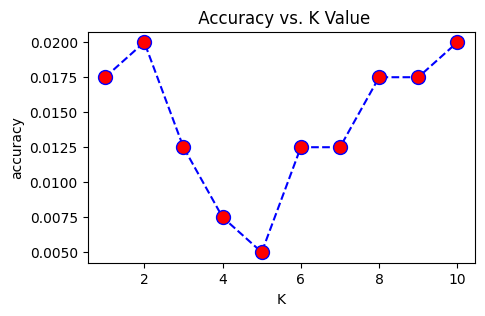

In [24]:
plt.figure(figsize=(5,3))
plt.plot(range(1,11),Haralink_accuracy,color='blue',linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title(' Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

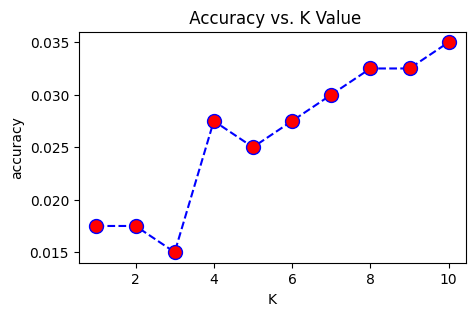

In [25]:
plt.figure(figsize=(5,3))
plt.plot(range(1,11),HOG_accuracy,color='blue',linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title(' Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

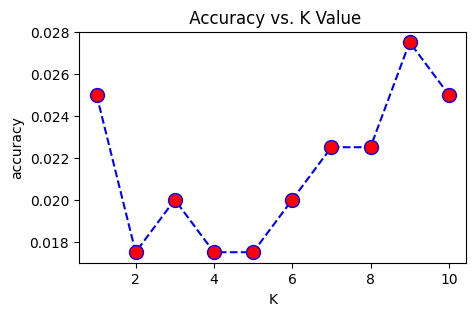

In [26]:
plt.figure(figsize=(5,3))
plt.plot(range(1,11),ORB_accuracy,color='blue',linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title(' Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('accuracy')

#### model2:SVM

In [17]:
model2 = SVC()
model2.fit(Haralink_x,Haralink_y)
SVM_predH = model2.predict(Haralink_tx)
accuracy_score(SVM_predH,Haralink_ty)

0.02

In [18]:
model2_HOG = SVC()
model2_HOG.fit(HOG_x,HOG_y)
SVM_predHOG = model2_HOG.predict(HOG_tx)
accuracy_score(SVM_predHOG,HOG_ty)

0.0775

In [19]:
model2_ORB = SVC()
model2_ORB.fit(ORB_x,ORB_y)
SVM_predORB = model2_ORB.predict(ORB_tx)
accuracy_score(SVM_predORB,ORB_ty)

0.0675

In [20]:
import pickle
# save the iris classification model as a pickle file
model_pkl_file = "SVM_model_Haralink.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model2, file)

# save the iris classification model as a pickle file
model_pkl_file = "SVM_model_HOG.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model2_HOG, file)

# save the iris classification model as a pickle file
model_pkl_file = "SVM_model_ORB.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model2_ORB, file)

#### model3: CatBoostClassifier

In [27]:
model3 = CatBoostClassifier(iterations=400,task_type="CPU",eval_metric = 'AUC', learning_rate=0.1, verbose=0)
model3.fit(Haralink_x,Haralink_y, eval_set=[(Haralink_x, Haralink_y), (Haralink_vx, Haralink_vy)], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [29]:
Cat_predH = model3.predict(Haralink_tx)
accuracy_score(Cat_predH,Haralink_ty)

0.085

In [30]:
import pickle
# save the iris classification model as a pickle file
model_pkl_file = "CatBoostClassifier_Haralink_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model3, file)

# load model from pickle file
with open(model_pkl_file, 'rb') as file:  
    modelnew = pickle.load(file)

# evaluate model 
y_predict = modelnew.predict(Haralink_tx)
accuracy_score(y_predict,Haralink_ty)

0.085

In [3]:
model3_1 = CatBoostClassifier(iterations=400,task_type="CPU",eval_metric = 'AUC', learning_rate=0.1, verbose=0)
model3_1.fit(HOG_x,HOG_y, eval_set=[(HOG_x, HOG_y), (HOG_vx, HOG_vy)], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [4]:
Cat_predHOG = model3_1.predict(HOG_tx)
accuracy_score(Cat_predHOG,HOG_ty)

0.08

In [ ]:
import pickle
# save the iris classification model as a pickle file
model_pkl_file = "CatBoostClassifier_HOG_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model3_1, file)

# load model from pickle file
with open(model_pkl_file, 'rb') as file:  
    modelnew = pickle.load(file)

# evaluate model 
Cat_predHOG = model3_1.predict(HOG_tx)
accuracy_score(Cat_predHOG,HOG_ty)

In [3]:
model3_2 = CatBoostClassifier(iterations=400,task_type="CPU",eval_metric = 'AUC', learning_rate=0.1, verbose=0)
model3_2.fit(ORB_x,ORB_y, eval_set=[(ORB_x, ORB_y), (ORB_vx, ORB_vy)], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [4]:
Cat_predORB = model3_2.predict(ORB_tx)
accuracy_score(Cat_predORB,ORB_ty)

0.0825

In [5]:
import pickle
# save the iris classification model as a pickle file
model_pkl_file = "CatBoostClassifier_ORB_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model3_2, file)

# load model from pickle file
with open(model_pkl_file, 'rb') as file:  
    modelnew = pickle.load(file)

# evaluate model 
Cat_predORB = model3_2.predict(ORB_tx)
accuracy_score(Cat_predORB,ORB_ty)

0.0825